In [1]:
import numpy as np
from scipy import optimize
import itertools
import math
import random
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

In [2]:
def k_LP(k,a,eps):
    var_n = int(math.pow(2,k))-1; ub_n = int(math.pow(2,k-1)*k)
    l = np.zeros(k)
    for i in range(k):
        l[i] = int(i)
    p = np.zeros(k)
    p[0] = 1; comb = [0]*(k)
    for i in range(1,k):
        p[i] = p[i-1] + math.comb(k,i)
        comb[i] = list(itertools.combinations(l,i))
    t = np.ones(var_n)
    u = 1
    for h in range(1,k):
        for i in range(int(math.comb(k,h))):
            for j in range(h):
                t[u] *= (a[int(comb[h][i][j])]-1)
            u += 1
    
    A_ub = np.zeros((ub_n,var_n))
    r = 0
    for i in range(k):
        A_ub[r][0] = -1; A_ub[r][i+1] = 1
        r += 1
    g = 1
    for h in range(1,k-1):
        for i in range(int(math.comb(k,h))):
            for j in range(int(math.comb(k,h+1))):
                f = np.zeros(h)
                for z in range(h):
                    for v in range(h+1):
                        if comb[h+1][j][v] == comb[h][i][z]:
                            f[z] = 1
                            break
                if np.sum(f) == h:
                    A_ub[r][g] = -1; A_ub[r][int(p[h])+j] = 1
                    r += 1
            g += 1
    for i in range(k):
        A_ub[r+i][int(p[k-2])+i] = -1
    
    #print(A_ub)
    
    b_ub = np.zeros(ub_n)
    for i in range(k):
        b_ub[ub_n-1-i] = -1
        
    #print(b_ub)
    
    A_eq = np.zeros((k,var_n))
    for s in range(k):
        A_eq[s][0] = 1
        c = 1
        for h in range(1,k):
            for i in range(int(math.comb(k,h))):
                ff = 0
                for j in range(h):
                    if comb[h][i][j] == s:
                        ff = 1
                        break
                if ff == 1:
                    A_eq[s][c] = -(t[c]*math.exp(eps[s]))/(a[s]-1)
                else:
                    A_eq[s][c] = t[c]
                c += 1
    #print(A_eq)
    
    b_eq = np.zeros(k)
    st = 1
    for i in range(k):
        st *= (a[i]-1)
    for s in range(k):
        b_eq[s] = (st*math.exp(eps[s]))/(a[s]-1)
    
    #print(b_eq)
    
    d = np.zeros(var_n); d[0] = 1
    
    ans = optimize.linprog(d,A_ub,b_ub,A_eq,b_eq)
    
    #print(ans.status)
    #print(ans.success)
    #print(ans.message)
        
    return ans

In [3]:
def two_opt(a,eps):
    c = math.exp(eps[0]); d = math.exp(eps[1])
    if c*d >= (a[0]-1)*(a[1]-1) and a[1]*c-a[0]*d+a[0]-a[1] >= 0:
        s0 = (a[1]*c*d+(a[0]-1)*(a[1]-1)*d-(a[0]-1)*(a[1]-1))/(d+a[1]-1)
        s1 = 1
        s2 = (a[1]*c-(a[0]-1)*d+a[0]-1)/(d+a[1]-1)
    elif c*d >= (a[0]-1)*(a[1]-1) and a[1]*c-a[0]*d+a[0]-a[1] < 0:
        s0 = (a[0]*c*d+(a[0]-1)*(a[1]-1)*c-(a[0]-1)*(a[1]-1))/(c+a[0]-1)
        s1 = (-(a[1]-1)*c+a[0]*d+a[1]-1)/(c+a[0]-1)
        s2 = 1
    elif c*d < (a[0]-1)*(a[1]-1) and (a[0]-a[1])*c*d+a[0]*(a[1]-1)*c-(a[0]-1)*a[1]*d >= 0:
        s0 = ((a[0]-1)*c*(d+a[1]-1))/(-c*d+c+(a[0]-1)*a[1])
        s1 = ((a[1]-1)*c*d-(a[1]-1)*c+(a[0]-1)*a[1]*d)/(-c*d+c+(a[0]-1)*a[1])
        s2 = ((a[0]-1)*c*(d+a[1]-1))/(-c*d+c+(a[0]-1)*a[1])
    else:
        s0 = ((a[1]-1)*d*(c+a[0]-1))/(-c*d+d+a[0]*(a[1]-1))
        s1 = ((a[1]-1)*d*(c+a[0]-1))/(-c*d+d+a[0]*(a[1]-1))
        s2 = ((a[0]-1)*c*d+a[0]*(a[1]-1)*c-(a[0]-1)*d)/(-c*d+d+a[0]*(a[1]-1))
    s3 = 1
    return s0,s1,s2

def k_inductive(k,a,eps):
    x = np.zeros((k+1,k+1))
    x[2][0],x[2][1],x[2][2] = two_opt([a[0],a[1]],[eps[0],eps[1]])
    s = a[0]; p = a[0]
    for i in range(3,k+1):
        for j in range(1,i):
            x[i][j] = a[i-1]*x[i-1][j]-a[i-1]+1
        s += a[i-2]; p *= a[i-2]
        s0 = 0
        for j in range(1,i):
            s0 += (a[j-1]-1)*x[i][j]
        left = [[1,a[i-1]-1], [1,-math.exp(eps[i-1])]]
        right = [a[i-1]*x[i-1][0], -s0-p+s-i+2+math.exp(eps[i-1])*(p-1)]
        x[i][0],x[i][i] = np.linalg.solve(left,right)
        f = 0
        if x[i][0] < 1 or x[i][i] < 1:
            f = 1
        for j in range(1,i+1):
            if x[i][0] < x[i][j]:
                f = 1; break
        if f == 1:
            x[i][0] = a[i-1]*x[i-1][0]-a[i-1]+1
            x[i][i] = 1
            eps[i-1] = math.log((x[i][0]+s0+p-s+i-2)/(x[i][i]+p-1))
            
    return x[k],eps

In [4]:
def Kronecker(k,eps):
    s = 0
    for i in range(k):
        s += eps[i]
    return s

In [5]:
def evaluation(k):
    t = 200
    p = np.zeros((t,4)); s = np.zeros(t); index = np.zeros(t)
    a = np.zeros(k); aa = np.zeros(t)
    
    for i in range(t):
        index[i] = i; aa[i] = 0
        for j in range(k):
            a[j] = int(random.uniform(2,5))
            aa[i] += a[j]
        h_ans,eps = k_inductive(k,a,3*np.ones(k))
        s[i] = Kronecker(k,eps)
        p[i][0] = 1
        p[i][1] = math.log(h_ans[0])/s[i]
        opt = k_LP(k,a,eps)
        p[i][2] = math.log(opt.x[0])/s[i]
        p[i][3] = aa[i]
    
    p = sorted(p, key=lambda x: x[3])
    privacy = np.zeros((t,3)); sa = np.zeros(t); optimality = np.zeros(t)
    for i in range(t):
        for j in range(3):
            privacy[i][j] = p[i][j]
        optimality[i] = p[i][1]/p[i][2]
        sa[i] = p[i][3]

    return privacy, optimality, sa

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


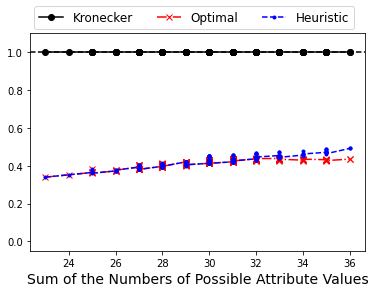

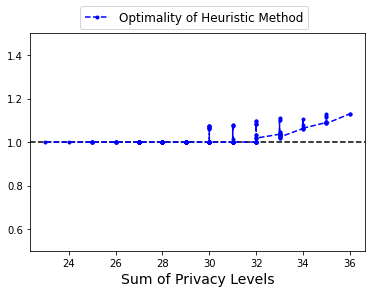

In [6]:
# k = 10

privacy, optimality, s = evaluation(10)

fig = plt.figure()
plt.ylim(-0.05, 1.1)
plt.axhline(1, ls="--",color="black")
plt.plot(s,privacy[:,0],marker="o",color="black",linestyle = "-",label="Kronecker")
plt.plot(s,privacy[:,2],marker="x",color="red",linestyle = "dashdot",label="Optimal")
plt.plot(s,privacy[:,1],marker=".",color="blue",linestyle = "--",label="Heuristic")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("Sum of the Numbers of Possible Attribute Values",fontsize=14)
fig.savefig("Privacy_eps_k=10.png")
fig.savefig("figs/Privacy_eps_k=10.eps")

fig = plt.figure()
plt.ylim(0.5, 1.5)
plt.axhline(1, ls="--",color="black")
plt.plot(s,optimality,marker=".",color="blue",linestyle = "--", label = "Optimality of Heuristic Method")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("Sum of Privacy Levels",fontsize=14)
fig.savefig("Optimality_eps_k=10.png")
fig.savefig("figs/Optimality_eps_k=10.eps")